__Goal : To detect the fraud in transactions__

In the datasets like fraud detection, customer churn, device failure, disease prediction the dataset is always imbalanced.
The rate of fraud, customer churn, device failure, diseased patients is usually low. So when such dataset is provided for training-
The training data provided contains very less value of such particular class. So model doesn't have much to learn from it.There is a huge bias in the dataset which should be solved to get the exact predictions.

1. Step1: Initially solving using unbalanced dataset (Logistic Regression to check for performance)

2. Step2: Later solving using balanced dataset using different balancing methods and hyper parameter tuning.
    
        1.using OVERSAMPLING
        
3. Step3:  Selecting the best model from hyper parameter tuning scores to train the model.Freezing the model using Joblib for further predictions. Pipelines can be created and model can be deployed using flask/django.


__Questions:__

1. Data cleaning including missing values, outliers and multi-collinearity.
    
        No missing values, outlier can be handled using 3 standard deviation, IQR OR PERCENTILE METHOD.

2. Describe your fraud detection model in elaboration.
        
        Dataset was cleaned, preprocessed and prepared for the predictions using various techniques.
        Decision tree was selected as the best model with criterion: 'entropy' to predict the fraudulent transactions which was 
        selected after performing hyperparameter tuning. 

3. How did you select variables to be included in the model?
    
        Correlation used to detect the column dependencies. 
        Columns having ID or name which was irrelevant for ML model was removed.
        Also we understand that in 'type' column only TRANSFER and CASH_OUT consists all fraud values.
        Rest of the rows can be dropped safely.

4. Demonstrate the performance of the model by using best set of tools.
        
        Hyperparameter tuning was performed to find the best model with parameters (99 % accuracy was achieved using decision
        tree)
        Cross validation of cv =5 used to find the score of best model. (avg accuracy achieved for decision tree = 99.98% )
        Confusion matrix was plotted to find TruePositives,TrueNegatives,FalsePositives,FalseNegatives

5. What are the key factors that predict fraudulent customer?

        1. Fraud transactions occured in rows containing these 2 categories: TRANSFER and CASH_OUT (8213 total cases) 
        2. 8034 out of 8213 cases all amount from  'oldbalanceOrg' column was transacted when the transaction was fraud in these 2 categories:     TRANSFER and CASH_OUT.
        3. 8053 out of 8213 times newbalanceOrig is 0 as all amount was removed in these 2
           categories:     TRANSFER and CASH_OUT.
        4. For 159 out of 160 times when newbalanceOrig values not equal to 0 : the amount was > 200000 & the transaction was fraud.
    
        columns: oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest

6. Do these factors make sense? If yes, How? If not, How not?
    
        Yes. The account sheet must balance the transactions made from sender to receiver. 
        If any non-adherence to the values are detected it denotes the likelihood of fraudulent cases or errors.
        Separate dataframe consisting this errors is created for analysis.

7. What kind of prevention should be adopted while company update its infrastructure?

        Machine learning model can be deployed to analyse for suspicious activity.
        Warnings/prompts/alerts for such activity can be raised and transactions can be monitored to avoid any frauds.

8. Assuming these actions have been implemented, how would you determine if they work?

        Testing the model on the test data and using the cross validation scores we will get the accuracy of the model. 
        Also metrics such as Precision, recall and f1 score will be used to evaluate the performance of the model.


__Importing libraries and csv__

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn

In [3]:
df = pd.read_csv('Fraud.csv')
df.shape

(6362620, 11)

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Exploration

In [5]:
df.isnull().sum() ##checking null values in dataframe

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
df = df.astype({"amount":'int', "oldbalanceOrg":'int',"newbalanceOrig":'int',"oldbalanceDest":'int',"newbalanceDest":'int','step':'int','isFraud':'int','isFlaggedFraud':'int'})
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839,C1231006815,170136,160296,M1979787155,0,0,0,0
1,1,PAYMENT,1864,C1666544295,21249,19384,M2044282225,0,0,0,0
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
3,1,CASH_OUT,181,C840083671,181,0,C38997010,21182,0,1,0
4,1,PAYMENT,11668,C2048537720,41554,29885,M1230701703,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682,C786484425,339682,0,C776919290,0,339682,1,0
6362616,743,TRANSFER,6311409,C1529008245,6311409,0,C1881841831,0,0,1,0
6362617,743,CASH_OUT,6311409,C1162922333,6311409,0,C1365125890,68488,6379898,1,0
6362618,743,TRANSFER,850002,C1685995037,850002,0,C2080388513,0,0,1,0


In [8]:
df.dtypes # no floats 

step               int32
type              object
amount             int32
nameOrig          object
oldbalanceOrg      int32
newbalanceOrig     int32
nameDest          object
oldbalanceDest     int32
newbalanceDest     int32
isFraud            int32
isFlaggedFraud     int32
dtype: object

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798614e+05,8.338830e+05,8.551135e+05,1.100701e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924048e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338900e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487150e+04,1.420800e+04,0.000000e+00,1.327050e+05,2.146610e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087210e+05,1.073150e+05,1.442580e+05,9.430362e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrg'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>,
        <AxesSubplot:title={'center':'newbalanceDest'}>],
       [<AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'isFlaggedFraud'}>, <AxesSubplot:>]],
      dtype=object)

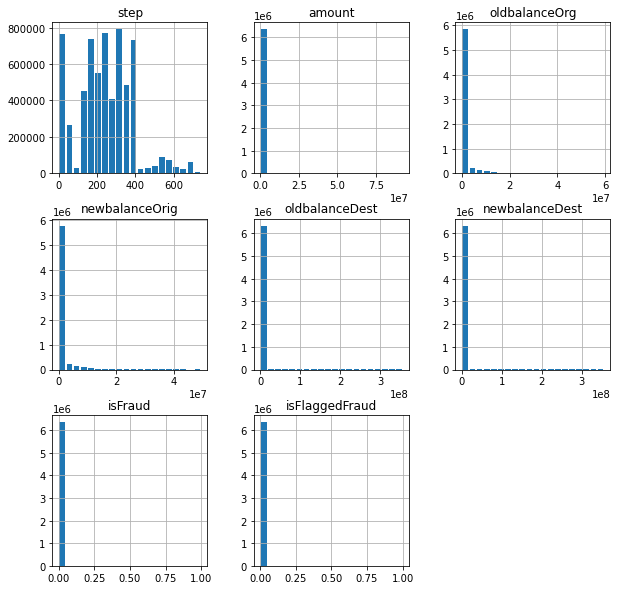

In [10]:
hist_bars = df.hist (bins= 20, figsize = (10,10), rwidth=0.8) #only numeric columns with dtype int or float are plotted
hist_bars

__Correlation__

    Pearsons correlation coefficient lies between -1 to 1, where -1 
    indicates strong negative correlation and 1 indicates strong positive correlation.
    -1 indicates that POSITIVE changes in A will result in stronger NEGATIVE changes in B
    -0.1 indicates that POSITIVE changes in A will result in weaker NEGATIVE changes in B
    1 indicates that POSITIVE changes in A will result in stronger POSITIVE changes in B
    0.1 indicates that POSITIVE changes in A will result in weaker POSITIVE changes in B

In [11]:
corr_matrix= df.corr()
corr_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066242,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066242,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


In [12]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [13]:
# Taking only columns with dtypes int32 and converting pandas series to numpy array for correlation.
corr_columns = df.dtypes[(df.dtypes=='int')].keys().to_numpy()
corr_columns

array(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype=object)

In [14]:
list(corr_columns)

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [15]:
df_corr = df[list(corr_columns)]
df_corr

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839,170136,160296,0,0,0,0
1,1,1864,21249,19384,0,0,0,0
2,1,181,181,0,0,0,1,0
3,1,181,181,0,21182,0,1,0
4,1,11668,41554,29885,0,0,0,0
...,...,...,...,...,...,...,...,...
6362615,743,339682,339682,0,0,339682,1,0
6362616,743,6311409,6311409,0,0,0,1,0
6362617,743,6311409,6311409,0,68488,6379898,1,0
6362618,743,850002,850002,0,0,0,1,0


In [16]:
df_corr.dtypes

step              int32
amount            int32
oldbalanceOrg     int32
newbalanceOrig    int32
oldbalanceDest    int32
newbalanceDest    int32
isFraud           int32
isFlaggedFraud    int32
dtype: object

array([[<AxesSubplot:xlabel='step', ylabel='step'>,
        <AxesSubplot:xlabel='amount', ylabel='step'>,
        <AxesSubplot:xlabel='oldbalanceOrg', ylabel='step'>,
        <AxesSubplot:xlabel='newbalanceOrig', ylabel='step'>,
        <AxesSubplot:xlabel='oldbalanceDest', ylabel='step'>,
        <AxesSubplot:xlabel='newbalanceDest', ylabel='step'>,
        <AxesSubplot:xlabel='isFraud', ylabel='step'>,
        <AxesSubplot:xlabel='isFlaggedFraud', ylabel='step'>],
       [<AxesSubplot:xlabel='step', ylabel='amount'>,
        <AxesSubplot:xlabel='amount', ylabel='amount'>,
        <AxesSubplot:xlabel='oldbalanceOrg', ylabel='amount'>,
        <AxesSubplot:xlabel='newbalanceOrig', ylabel='amount'>,
        <AxesSubplot:xlabel='oldbalanceDest', ylabel='amount'>,
        <AxesSubplot:xlabel='newbalanceDest', ylabel='amount'>,
        <AxesSubplot:xlabel='isFraud', ylabel='amount'>,
        <AxesSubplot:xlabel='isFlaggedFraud', ylabel='amount'>],
       [<AxesSubplot:xlabel='step', ylabel

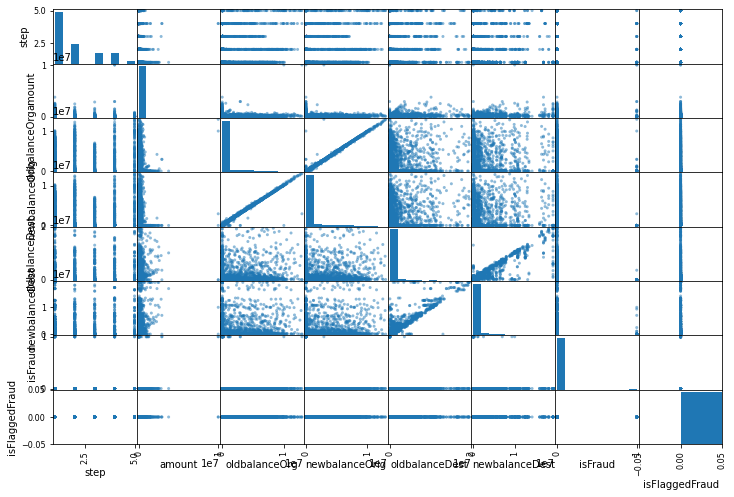

In [17]:
# Plotting first 50000 values scatter plot
from pandas.plotting import scatter_matrix
scatter_plot = scatter_matrix(df[0:5000], figsize = (12,8))
scatter_plot

In [18]:
skew =df.skew().sort_values(ascending =False )
skew

isFlaggedFraud    630.603629
amount             30.993949
isFraud            27.779538
oldbalanceDest     19.921759
newbalanceDest     19.352303
oldbalanceOrg       5.249137
newbalanceOrig      5.176884
step                0.375177
dtype: float64

In [19]:
skew_df= pd.DataFrame({'skew':skew})
skew_df.head(10)

,skew
isFlaggedFraud,630.603629
amount,30.993949
isFraud,27.779538
oldbalanceDest,19.921759
newbalanceDest,19.352303
oldbalanceOrg,5.249137
newbalanceOrig,5.176884
step,0.375177


    We understand that our data is skewed here. 
    The data is not normally distributed and we do not see any bell curve in the data.
    We can tackle this using IQR, standard deviation or percentile method.
    Lets explore the dataset further.

In [20]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [21]:
df[df.type=='TRANSFER'].isFraud.value_counts()

0    528812
1      4097
Name: isFraud, dtype: int64

In [22]:
df[df.type=='CASH_OUT'].isFraud.value_counts()

0    2233384
1       4116
Name: isFraud, dtype: int64

In [23]:
4097 + 4116

8213

Data Dictionary says : Note that there is not information for customers that start with M (Merchants).
    
    Lets check that data

In [24]:
df[df.nameDest.str.contains('M')].oldbalanceDest.value_counts()
# We do not see any other value than 0

0    2151495
Name: oldbalanceDest, dtype: int64

In [25]:
df[df.nameDest.str.contains('M')].newbalanceDest.value_counts()
# We do not see any other value than 0

0    2151495
Name: newbalanceDest, dtype: int64

    We do not see any other value than 0 for newbalanceDest and oldbalanceDest when M was first letter in nameDest.
    Although all type rows were selected in this case. We are concerned only with this 2 categories :

        1. TRANSFER row
        2. CASH_OUT row

    The rest of the rows does not matter.Lets checkout if M is contained in these two categories: 

In [26]:
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()

False

In [27]:
(df.loc[df.type == 'TRANSFER'].nameDest.str.contains('M')).any()

False

    M is not contained in these two categories:    1. TRANSFER row 2. CASH_OUT row 
    Also we understand that in 'type' column only TRANSFER and CASH_OUT consists all fraud.
    So we can safely drop the rest of the rows from our dataframe.

In [28]:
df1 = df[(df.type=='TRANSFER') |(df.type=='CASH_OUT')]
df1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
3,1,CASH_OUT,181,C840083671,181,0,C38997010,21182,0,1,0
15,1,CASH_OUT,229133,C905080434,15325,0,C476402209,5083,51513,0,0
19,1,TRANSFER,215310,C1670993182,705,0,C1100439041,22425,0,0,0
24,1,TRANSFER,311685,C1984094095,10835,0,C932583850,6267,2719172,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682,C786484425,339682,0,C776919290,0,339682,1,0
6362616,743,TRANSFER,6311409,C1529008245,6311409,0,C1881841831,0,0,1,0
6362617,743,CASH_OUT,6311409,C1162922333,6311409,0,C1365125890,68488,6379898,1,0
6362618,743,TRANSFER,850002,C1685995037,850002,0,C2080388513,0,0,1,0


In [29]:
df1.isFraud.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

___Column 0: step column___

In [30]:
df1.step.unique() #Unique values in step column

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [31]:
df1.step.value_counts() #checking value counts for step column

19     23768
18     23330
187    22546
235    22200
139    21559
       ...  
28         4
693        4
54         4
662        2
112        2
Name: step, Length: 743, dtype: int64

    We will Plot the step column vs count and find the distribution of values. 

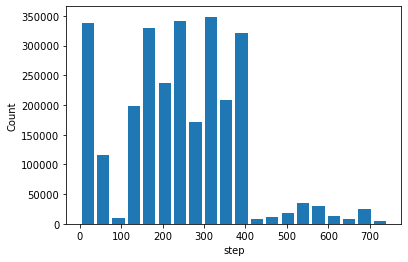

In [32]:
plt.hist(df1.step, bins=20, rwidth=0.8)
plt.xlabel('step')
plt.ylabel('Count')
plt.show()

    step column will be dropped further

___Column 1 : type column___

In [33]:
df1.type.value_counts() # Exploring the type column

CASH_OUT    2237500
TRANSFER     532909
Name: type, dtype: int64

    Type columns contains 2 categories of dtype as object. 
    Converting them to discrete values of 1 and 0 using One-Hot-Encoding.

In [34]:
dummies = pd.get_dummies(df1.type)
dummies.head()

,CASH_OUT,TRANSFER
2,0,1
3,1,0
15,1,0
19,0,1
24,0,1


In [35]:
df2 = pd.concat([df1,dummies], axis = 'columns')
df2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,TRANSFER
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0,0,1
3,1,CASH_OUT,181,C840083671,181,0,C38997010,21182,0,1,0,1,0
15,1,CASH_OUT,229133,C905080434,15325,0,C476402209,5083,51513,0,0,1,0
19,1,TRANSFER,215310,C1670993182,705,0,C1100439041,22425,0,0,0,0,1
24,1,TRANSFER,311685,C1984094095,10835,0,C932583850,6267,2719172,0,0,0,1


__Data Cleaning__

___column: isFraud and isFlaggedFraud column___

In [36]:
df2.isFraud.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

    Using isFraud as a target column

In [37]:
df2.isFlaggedFraud.value_counts() 

0    2770393
1         16
Name: isFlaggedFraud, dtype: int64

    isFlaggedFraud contains very less values of 1 as compared to 0. 
    It would not affect the training set. 
    Balancing this values might reduce down the 0 or increase 1 to much greater extent.
    Dropping 'isFlaggedFraud' column and observe the results.

The following columns will be dropped:

    1. 'type': column converted to dummies.
    2. 'TRANSFER': dropping this column to avoid the dummy variable trap.
    3. nameOrig- contains ID 
    4. nameDest- contains ID 
    5. step - This column does not affect the output. 
    
    

In [38]:
df3 = df2.drop(['type','TRANSFER','nameOrig','nameDest','step','isFlaggedFraud'], axis = 'columns')
df3

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT
2,181,181,0,0,0,1,0
3,181,181,0,21182,0,1,1
15,229133,15325,0,5083,51513,0,1
19,215310,705,0,22425,0,0,0
24,311685,10835,0,6267,2719172,0,0
...,...,...,...,...,...,...,...
6362615,339682,339682,0,0,339682,1,1
6362616,6311409,6311409,0,0,0,1,0
6362617,6311409,6311409,0,68488,6379898,1,1
6362618,850002,850002,0,0,0,1,0


__Detecting the reason of frauds__

In [39]:
fraudDS = df3[df3.isFraud==1]

In [40]:
nofraudDS = df3[df3.isFraud==0]

In [41]:
fraudDS.shape # total fraud cases

(8213, 7)

In [42]:
nofraudDS.shape #total no fraud cases

(2762196, 7)

In [43]:
fraudDS[fraudDS.amount==fraudDS.oldbalanceOrg].shape
# All the oldbalanceOrg amount was transacted when the transaction was fraud in 8034 out of 8213 cases.

(8034, 7)

In [44]:
fraudDS[fraudDS.newbalanceOrig==0].shape
# 8053 out of 8213 times newbalanceOrig is 0 as all amount was removed.

(8053, 7)

In [45]:
fraudDS[fraudDS.newbalanceOrig!=0].shape

(160, 7)

In [46]:
# For 160 values not equal to 0 ,lets find the reason behind this stats.
fraudDS[fraudDS.newbalanceOrig!=0].newbalanceOrig.describe()

count    1.600000e+02
mean     9.875754e+06
std      1.016499e+07
min      1.755970e+05
25%      2.604515e+06
50%      5.793376e+06
75%      1.447791e+07
max      4.958504e+07
Name: newbalanceOrig, dtype: float64

In [47]:
(fraudDS[fraudDS.newbalanceOrig!=0])[fraudDS.amount>200000]
# For 159 out of 160 times when newbalanceOrig values not equal to 0 : the amount was > 200000 & the transaction was fraud.

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT
4440,10000000,12930418,2930418,0,0,1,0
60853,994453,1437370,442917,194812,665743,1,0
481250,10000000,11861008,1861008,0,0,1,0
586311,10000000,19887819,9887819,0,0,1,0
1030559,10000000,18594065,8594065,0,0,1,0
...,...,...,...,...,...,...,...
6362576,10000000,45674547,35674547,0,0,1,0
6362578,10000000,35674547,25674547,0,0,1,0
6362580,10000000,25674547,15674547,0,0,1,0
6362582,10000000,15674547,5674547,0,0,1,0


In [48]:
(fraudDS[fraudDS.newbalanceOrig!=0])[fraudDS.amount<200000]
# 1 out of 160 case that was termed as fraud with amount < 200000

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT
377151,42062,340830,298767,398931,678419,1,1


In [49]:
fraudDS[fraudDS.newbalanceDest<fraudDS.amount].shape
# 4122 out of 8213 times newbalanceDest was less than amount transacted.

(4122, 7)

In [50]:
fraudDS[(fraudDS.newbalanceDest==0) & (fraudDS.amount!=0)].shape

(4085, 7)

In [51]:
4085/8213 # 50% cases newbalanceDest==0 when amount!=0 for fraud 

0.4973821989528796

In [52]:
fraudDS[(fraudDS.newbalanceDest==0) &(fraudDS.oldbalanceDest==0)& (fraudDS.amount!=0)].shape

(4070, 7)

In [53]:
4070/8213

0.4955558261293072

In [54]:
fraudDS[(fraudDS.oldbalanceOrg==0) &(fraudDS.newbalanceOrig==0)& (fraudDS.amount!=0)].shape

(25, 7)

In [55]:
25/8213*100 

0.30439547059539757

In [56]:
fraudDS[:10]

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT
2,181,181,0,0,0,1,0
3,181,181,0,21182,0,1,1
251,2806,2806,0,0,0,1,0
252,2806,2806,0,26202,0,1,1
680,20128,20128,0,0,0,1,0
681,20128,20128,0,6268,12145,1,1
724,416001,0,0,102,9291619,1,1
969,1277212,1277212,0,0,0,1,0
970,1277212,1277212,0,0,2444985,1,1
1115,35063,35063,0,0,0,1,0


__Detecting the reason of nofrauds__

In [57]:
nofraudDS[:10]

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT
15,229133,15325,0,5083,51513,0,1
19,215310,705,0,22425,0,0,0
24,311685,10835,0,6267,2719172,0,0
42,110414,26845,0,288800,2415,0,1
47,56953,1942,0,70253,64106,0,1
48,5346,0,0,652637,6453430,0,1
51,23261,20411,0,25742,0,0,1
58,62610,79114,16503,517,8383,0,0
60,82940,3017,0,132372,49864,0,1
70,47458,209534,162075,52120,0,0,1


In [58]:
209534-47458

162076

In [59]:
nofraudDS[nofraudDS.amount==nofraudDS.oldbalanceOrg].shape
# only 1 case out of 2762196 the amount = oldbalanceOrg 

(1, 7)

In [60]:
nofraudDS[nofraudDS.newbalanceOrig==0].shape
# cases when newbalanceOrig = 0

(2488607, 7)

In [61]:
nofraudDS[nofraudDS.amount>nofraudDS.oldbalanceOrg].shape
# cases when amount > oldbalanceOrg

(2488604, 7)

In [62]:
nofraudDS[nofraudDS.newbalanceDest==(nofraudDS.oldbalanceDest + nofraudDS.amount)].shape
# These are likely to be the correct 

(1444676, 7)

In [63]:
nofraudDS[nofraudDS.oldbalanceOrg==(nofraudDS.newbalanceOrig + nofraudDS.amount)].shape
# These are likely to be the correct

(40222, 7)

In [64]:
nofraudDS[(nofraudDS.newbalanceDest==0) & (nofraudDS.amount!=0)].shape

(12506, 7)

In [65]:
12506/2762196*100 # 0.452% cases newbalanceDest==0 when amount!=0 for nofraud

0.4527557059672811

In [66]:
nofraudDS[(nofraudDS.newbalanceDest==0) & (nofraudDS.oldbalanceDest==0) & (nofraudDS.amount!=0)].shape

(1704, 7)

In [67]:
1704/2762196*100 # 0.0616% cases newbalanceDest==oldbalanceDest==0 when amount!=0 for nofraud

0.06169004661508452

In [68]:
nofraudDS[(nofraudDS.oldbalanceOrg==0) & (nofraudDS.newbalanceOrig==0) & (nofraudDS.amount!=0)].shape

(1308542, 7)

In [69]:
1308542/2762196*100

47.37324940011498

In [70]:
nofraudDS[(nofraudDS.newbalanceDest==0)].shape

(12508, 7)

__Finding errors in transactions__

In [71]:
df4=df3.copy()

In [72]:
df4['error_balanceDest'] = df3.oldbalanceDest + df3.amount - df3.newbalanceDest
df4['error_balanceOrig'] = df3.newbalanceOrig + df3.amount - df3.oldbalanceOrg
df4

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,error_balanceDest,error_balanceOrig
2,181,181,0,0,0,1,0,181,0
3,181,181,0,21182,0,1,1,21363,0
15,229133,15325,0,5083,51513,0,1,182703,213808
19,215310,705,0,22425,0,0,0,237735,214605
24,311685,10835,0,6267,2719172,0,0,-2401220,300850
...,...,...,...,...,...,...,...,...,...
6362615,339682,339682,0,0,339682,1,1,0,0
6362616,6311409,6311409,0,0,0,1,0,6311409,0
6362617,6311409,6311409,0,68488,6379898,1,1,-1,0
6362618,850002,850002,0,0,0,1,0,850002,0


In [73]:
df4[df4.error_balanceDest!=0].shape

(1323036, 9)

In [74]:
1323036/2770409*100 # 47% error in destination transactions

47.755981156572915

In [75]:
df4[df4.error_balanceOrig!=0].shape

(2722020, 9)

In [76]:
2722020/2770409*100 # 98.25% error in origin transaction

98.25336259014463

    __All the error values can be imputed directly in the dataframe to the correct value, but that would affect the performance of the model.
    We can use negate value such as -1 to help the model understand better for all transaction columns: 
    (oldbalanceOrg,	newbalanceOrig,	oldbalanceDest,	newbalanceDest)
    Not imputing for now. Checking the performance without imputing

__Initially training a stand alone model using Logistic Regression. Later Hyperparameter tuning and model selection will be done.__

__Separating X and y:__

In [77]:
X= df3.copy()
X.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT
2,181,181,0,0,0,1,0
3,181,181,0,21182,0,1,1
15,229133,15325,0,5083,51513,0,1
19,215310,705,0,22425,0,0,0
24,311685,10835,0,6267,2719172,0,0


In [78]:
X = X.drop(['isFraud'], axis = 'columns')
X.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT
2,181,181,0,0,0,0
3,181,181,0,21182,0,1
15,229133,15325,0,5083,51513,1
19,215310,705,0,22425,0,0
24,311685,10835,0,6267,2719172,0


In [79]:
X.shape

(2770409, 6)

In [80]:
y = df3.isFraud
y.shape

(2770409,)

## Step 1. Solving using Unbalanced Dataset

__Train_test_splitting__

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2) # (flattened 2d array,1d array)

In [82]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2216327, 554082, 2216327, 554082)

__Logistic Regression StandAlone Model__

In [ ]:
# from sklearn.linear_model import LogisticRegression
# logmodel = LogisticRegression()
# logmodel.fit(X_train,y_train)

__Saving fit model to joblib file.__

In [83]:
import joblib
# joblib.dump(logmodel,'logmodel')
logmodel= joblib.load('logmodel')

In [84]:
logmodel.score(X_test,y_test)

0.9973072577705105

In [85]:
y_pred= logmodel.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
logmodel.predict_proba(X_test) 
# probablities of fraud happening. 
# Only logistic regression can predict this as it uses sigmoid function.

array([[8.13360106e-01, 1.86639894e-01],
       [9.99969390e-01, 3.06103383e-05],
       [9.99861227e-01, 1.38773206e-04],
       ...,
       [1.00000000e+00, 2.53027500e-11],
       [9.14401005e-01, 8.55989951e-02],
       [1.00000000e+00, 8.83048323e-68]])

In [87]:
np.unique(np.array(y_pred),return_counts= True) # to count unique 0 and 1 returned by predictions

(array([0, 1]), array([551841,   2241], dtype=int64))

Text(24.0, 0.5, 'True')

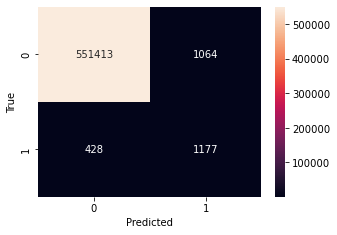

In [88]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
import seaborn as sn
plt.figure (figsize =(5,3.5))
sn.heatmap(cm, annot = True,fmt = "d" )
plt.xlabel("Predicted")
plt.ylabel("True")

In [89]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552477
           1       0.53      0.73      0.61      1605

    accuracy                           1.00    554082
   macro avg       0.76      0.87      0.81    554082
weighted avg       1.00      1.00      1.00    554082



    We observe that:
    1. Accuracy is 1: This might be an overfitting issue.Lets try balancing the dataset.
    2. As class 0 is the majority class the precision,f1,recall for class 0 is greater as compared to minority class of 1.
    3. For class 1 the f1,precision and recall can be improved by balancing the dataset. Supports for each class are not equal.

## Step 2. Solving using balanced dataset using different balancing methods.

__Balancing the dataset__
    
    Method1: Undersampling
    Method2: Oversampling
    Method3:SMOTE (Synthetic minority oversampling technique) - uses KNN algo
    Method4: Ensemble method (Majority vote)

**Using Method 2: Oversampling to trade a balance between computational time and accuracy of model**

## METHOD 2: Oversampling

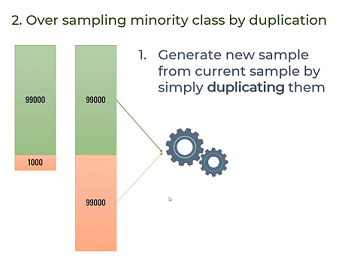

In [90]:
df3.isFraud.unique() #unique values

array([1, 0])

In [91]:
df3.isFraud.value_counts() #The dataset is highly imbalanced

0    2762196
1       8213
Name: isFraud, dtype: int64

In [92]:
count_class_0,count_class_1 =  df3.isFraud.value_counts()

In [93]:
count_class_0

2762196

In [94]:
count_class_1

8213

In [95]:
df_class_0 = df3[df3['isFraud']==0]
df_class_0['isFraud'].value_counts() # Only 1 class i.e. 0 with 5163 no of elements.

0    2762196
Name: isFraud, dtype: int64

In [96]:
df_class_1 = df3[df3['isFraud']==1]
df_class_1['isFraud'].value_counts() # Only 1 class i.e. 0 with 1869 no of elements.

1    8213
Name: isFraud, dtype: int64

In [97]:
df_class_0.shape

(2762196, 7)

In [98]:
df_class_1.shape

(8213, 7)

In [99]:
df_class_1_over = df_class_1.sample(count_class_0, replace = True)
df_class_1_over.shape

(2762196, 7)

In [100]:
df_test_over = pd.concat([df_class_0,df_class_1_over],axis = 0) #Combining the two dataframes 
df_test_over.shape

(5524392, 7)

In [101]:
df_test_over.isFraud.value_counts() # 1 is oversampled. 0 and 1 equally distributed.

0    2762196
1    2762196
Name: isFraud, dtype: int64

In [102]:
df_test_over

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT
15,229133,15325,0,5083,51513,0,1
19,215310,705,0,22425,0,0,0
24,311685,10835,0,6267,2719172,0,0
42,110414,26845,0,288800,2415,0,1
47,56953,1942,0,70253,64106,0,1
...,...,...,...,...,...,...,...
6359043,8443528,8443528,0,0,0,1,0
4775,86070,86070,0,0,0,1,0
5186345,140807,140807,0,137903,278711,1,1
5563708,10000000,10000000,0,109827,10109827,1,1


In [103]:
X = df_test_over.drop(['isFraud'],axis = 'columns')
y = df_test_over['isFraud']

In [104]:
X.shape

(5524392, 6)

In [105]:
y.shape

(5524392,)

In [106]:
y.value_counts()

0    2762196
1    2762196
Name: isFraud, dtype: int64

In [107]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify = y) 
# stratify ensures equal dist of X and y values while splitting.

In [108]:
def shape_print (X_train,X_test,y_train,y_test):
    list = [X_train,X_test,y_train,y_test]
    list1 = ['X_train','X_test','y_train','y_test']
    for i,j in zip(list,list1):
        print(f'{j} : {i.shape}')

In [109]:
def value_counts(y_train,y_test):
    print (y_train.value_counts())
    print (y_test.value_counts())

In [110]:
shape_print(X_train,X_test,y_train,y_test)

X_train : (4419513, 6)
X_test : (1104879, 6)
y_train : (4419513,)
y_test : (1104879,)


In [111]:
value_counts(y_train,y_test) # When Strat is  used

1    2209757
0    2209756
Name: isFraud, dtype: int64
0    552440
1    552439
Name: isFraud, dtype: int64


In [ ]:
# from sklearn.linear_model import LogisticRegression
# logmodel_balanced_OS = LogisticRegression()
# logmodel_balanced_OS.fit(X_train,y_train)

In [112]:
import joblib
# joblib.dump(logmodel_balanced_OS,'logmodel_balanced_OS')
logmodel_balanced_OS= joblib.load('logmodel_balanced_OS')

In [113]:
logmodel_balanced_OS.score(X_test,y_test) # Accuracy of 92%

0.9231264237984431

In [114]:
logmodel_balanced_OS.predict_proba(X_test)

array([[3.60343183e-01, 6.39656817e-01],
       [6.22403085e-04, 9.99377597e-01],
       [9.79350785e-01, 2.06492146e-02],
       ...,
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.33703345e-12],
       [2.52681989e-02, 9.74731801e-01]])

In [115]:
y_pred= logmodel_balanced_OS.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 0, 1])

Text(24.0, 0.5, 'True')

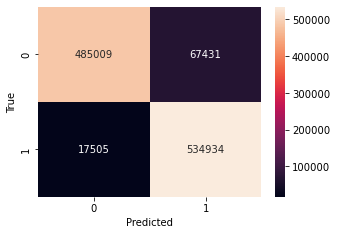

In [116]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
import seaborn as sn
plt.figure (figsize =(5,3.5))
sn.heatmap(cm, annot = True,fmt = "d" )
plt.xlabel("Predicted")
plt.ylabel("True")

In [117]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92    552440
           1       0.89      0.97      0.93    552439

    accuracy                           0.92   1104879
   macro avg       0.93      0.92      0.92   1104879
weighted avg       0.93      0.92      0.92   1104879



    We can see a significant improvement in precision recall and f1 score after balancing dataset.
    for class 0 precision recall and f1 dropped
    for class 1 precsion recall and f1 increased
    accuracy dropped from 1 to 0.92
    Lets check the accuracy using cross validation.

__Cross Validation Score__

In [118]:
from sklearn.model_selection import cross_val_score  # default n_splits= 5.Train test split is not required for C-validation
# scores = cross_val_score(LogisticRegression(),X,y)

In [119]:
import joblib
# joblib.dump(scores,'bal_cv_scores')
bal_cv_scores= joblib.load('bal_cv_scores')

In [120]:
bal_cv_scores

array([0.91217138, 0.92504428, 0.9245971 , 0.92858759, 0.9254162 ])

In [121]:
np.mean(bal_cv_scores)

0.9231633108423448

__Hyper Parameter Tuning__

    Using SKLEARN's Grid Search CV to fine tune our model and select the best model and parameters.

In [122]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# model_params = {                           # creating model parameters
#     'svm': {
#         'model': SVC(gamma='auto'),
#         'params': {
#             'C':[1,10,20],
#             'kernel': ['rbf','linear']
#         }
#     },
#     'random_forest':{
#         'model': RandomForestClassifier(),
#         'params': {
#             'n_estimators': [1,5,10]
#         }
#     },
#     'logistic_regression': {
#         'model': LogisticRegression(),
#         'params': {
#             'C': [1,5,10]
#         }
#     },
#      'Gaussian_NB': {
#         'model': GaussianNB(),
#         'params': {
       
#         }
#     },
#      'Multinomial_NB': {
#         'model': MultinomialNB(),
#         'params': {
           
#         }
#     },
#      'Decision_Tree_Classifier': {
#         'model': DecisionTreeClassifier(),
#         'params': {
#             'criterion': ['gini','entropy']
#         }
#     }
# }

    While all the above algorithms can be used to predict the fraud using gridsearchCV, decision tree performs well in the case of classification. Here, to reduce the computation time, intuitively selecting decision tree for further predictions.Comparison between ['gini','entropy'] parameters will be made and best parameter will be selected to build the model.

**Hypertuning models with multiple parameters is computationally expensive on CPU.**

**We can tackle this problem in following order of priority:** 
     
     1. Distributed training on GPU by parallel batch training methods.
     2. Randomized search CV (selecting the random combinations of parameters)
     3. Reducing the sample size for training (reducing training samples)

**Now just using Decision tree with parameters ['gini','entropy'] to find the scores with crossvalidation = 3**

In [ ]:
# model_params = {                           # creating model parameters
#      'Decision_Tree_Classifier': {
#         'model': DecisionTreeClassifier(),
#         'params': {
#             'criterion': ['gini','entropy']
#         }
#     }
# }

In [ ]:
# model_params1 = {                           # creating model parameters
#     'svm': {
#         'model': SVC(gamma='auto'),
#         'params': {
#             'C':[1,10,20],
#             'kernel': ['rbf','linear']
#         }
#     },
#     'random_forest':{
#         'model': RandomForestClassifier(),
#         'params': {
#             'n_estimators': [1,5,10]
#         }
#     },
#      'Decision_Tree_Classifier': {
#         'model': DecisionTreeClassifier(),
#         'params': {
#             'criterion': ['gini','entropy']
#         }
#     }
# }

In [123]:
# from sklearn.model_selection import GridSearchCV #takes (estimator, param_grid, cv)

In [ ]:
# HT_scores = []
# for i,j in model_params.items():
#     clf = GridSearchCV(j['model'], j['params'],cv =3)
#     clf.fit(X,y)
#     HT_scores.append({
#         'MODEL': i,
#         'BEST SCORE': clf.best_score_,
#         'BEST PARAMS': clf.best_params_
#     })
# HT_scores

In [ ]:
# HT_scores1 = []
# for i,j in model_params1.items():
#     clf = GridSearchCV(j['model'], j['params'],cv =3)
#     clf.fit(X,y)
#     HT_scores1.append({
#         'MODEL': i,
#         'BEST SCORE': clf.best_score_,
#         'BEST PARAMS': clf.best_params_
#     })
# HT_scores1

In [124]:
import joblib                
# joblib.dump(HT_scores1,'HT_scores')
HT_scores= joblib.load('HT_scores')
HT_scores

[{'MODEL': 'Decision_Tree_Classifier',
  'BEST SCORE': 0.9998097528198578,
  'BEST PARAMS': {'criterion': 'entropy'}}]

In [ ]:
# import joblib                
# joblib.dump(HT_scores1,'HT_scores1')
# HT_scores1= joblib.load('HT_scores1')
# HT_scores1

In [125]:
best_model = pd.DataFrame(HT_scores) # creating dataframe from the above scores 
best_model

,MODEL,BEST SCORE,BEST PARAMS
0,Decision_Tree_Classifier,0.99981,{'criterion': 'entropy'}


    We found decision tree with criterion: 'entropy' to be the best Algorithm that gives the best score.
    We can use this algorithm to further predict our model and create a pipeline.

## Step 3. Selecting the best model from hyper parameter tuning scores to train the model.

__Predicting using Decision tree: criterion: 'entropy'__

In [130]:
from sklearn import tree

In [ ]:
# DTmodel = tree.DecisionTreeClassifier(criterion='entropy')
# DTmodel.fit(X_train,y_train)

In [132]:
import joblib                
# joblib.dump(DTmodel,'DT_model')
DT_model= joblib.load('DT_model')
DT_model

DecisionTreeClassifier(criterion='entropy')

In [133]:
DT_model.score(X_test,y_test)

0.9999692273995614

In [134]:
y_pred= DT_model.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 0, 1])

In [135]:
from sklearn.model_selection import cross_val_score  # default n_splits= 5.Train test split is not required for C-validation
DT_scores = cross_val_score(tree.DecisionTreeClassifier(criterion='entropy'),X,y)

In [137]:
import joblib                
joblib.dump(DT_scores,'DT_scores')
DT_scores= joblib.load('DT_scores')
DT_scores

array([0.99973029, 0.99986876, 0.99986333, 0.99986424, 0.99984885])

In [143]:
np.mean(DT_scores)

0.9998350949880347

Text(24.0, 0.5, 'True')

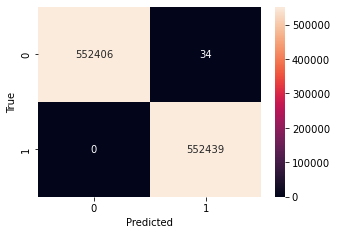

In [138]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
import seaborn as sn
plt.figure (figsize =(5,3.5))
sn.heatmap(cm, annot = True,fmt = "d" )
plt.xlabel("Predicted")
plt.ylabel("True")

In [139]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552440
           1       1.00      1.00      1.00    552439

    accuracy                           1.00   1104879
   macro avg       1.00      1.00      1.00   1104879
weighted avg       1.00      1.00      1.00   1104879



    Conclusion:
    Decision tree with entropy gave the best score of 99.98542826861584 % 
    Confusion matrix results of Decision Tree Classifier are better as compared to the logistic regression.
    Supports are balanced perfectly for values of 1 and 0
    Precision,recall and f1 score shows significant improvements.

In [140]:
X_test

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT
4877120,89241,87952,0,880310,969552,1
6333195,912950,912950,0,2316416,3229367,1
5373257,232894,0,0,682348,915243,0
4580662,364375,364375,0,1167810,1532186,1
1216102,420353,146783,0,221030,641383,1
...,...,...,...,...,...,...
718845,44885,207451,162566,903880,948765,1
1932211,18887,18887,0,0,0,0
3960329,10000000,10000000,0,920463,10920463,1
1573150,1722572,15121,0,356041,2078614,0


**Entering some random values to predict if fraud is detected using our joblib model.**

In [141]:
DT_model.predict([[123548,1254887,0,8745478,457878,1]]) # Case of fraud happening

array([1])

In [142]:
DT_model.predict([[0,12514887,0,8745478,457878,0]]) # Case of fraud not happening

array([0])

**Further pipelines can be created and model can be deployed using flask/django etc**